## Readme
**Bayesian Parameter estimation**   
Author: Wenfan Feng  
Date: 2020/12/14

## Packages 

In [2]:
# import pymc 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial
from scipy import signal
from scipy.fftpack import fft,ifft
from astropy import constants as const
from astropy.cosmology import FlatLambdaCDM
from math import sin,cos,sqrt,atan,acos,exp,log
%matplotlib inline

## Parameters

**定值用大写字母，参数用小写字母**

In [3]:
MsunInS = 4.926860879228572e-06   # solar mass in [s]
MpcInS  = 102927125053532.6       # mega parsec in [s]
OrbitRadiusInS = 1e8 /const.c.value    # 1e5 km
MearthInS      = const.M_earth.value*const.G.value/const.c.value**3
OrbitPeriodInS = 2*np.pi*np.sqrt(OrbitRadiusInS**3/MearthInS)
YearInS  = 31536000.0   # one year in [s]
AUInS   = const.au.value/const.c.value  # AU in [s]

In [4]:
Tc     = 0.49*YearInS    # chirp time
# Tc     = 0.0    # chirp time
Phic   = 0.954    # chirp phase

# ThetaS = np.arccos(np.random.uniform(-1,1)) 
# PhiS   = np.random.uniform(0,2*np.pi) 
# Iota   = np.arccos(np.random.uniform(-1,1)) 
# Psi    = np.random.uniform(0,2*np.pi)  
# print(ThetaS,PhiS,Iota,Psi)

ThetaS = 1.325
PhiS   = 2.04
Iota   = 1.02
Psi    = 0.658
print(ThetaS,PhiS,Iota,Psi)

1.325 2.04 1.02 0.658


In [5]:
Z      = 1.0    # cosmological redshift
M1sun  = 1e7    # solar mass as unit
M2sun  = 1e6    # solar mass as unit
Tobs   = 0.5   # year as unit 
# Chi1   = 0.1    # dimensionless parameter
# Chi2   = 0.0    # dimensionless parameter
cosmo  = FlatLambdaCDM(H0=67,Om0=0.32)
DL     = cosmo.luminosity_distance(Z).value*MpcInS # Mpc in second
M1     = (1+Z)*M1sun*MsunInS   # solar mass in second
M2     = (1+Z)*M2sun*MsunInS   # solar mass in second
M      = M1 + M2               # total mass
Qmr    = M1/M2                 # mass ratio
Mu     = M1*M2/M               # reduced mass
Mc     = Mu**(3./5)*M**(2./5)  # chirp mass
Eta    = M1*M2/M**2            # symmetric mass ratio

# Time-domain waveform

In [6]:
def ht_respon_TQ(t, tc, phic, mc, eta, dl, thetaS, phiS, iota, psi):
    
    #"""For TianQin (one Michelson interferometer): (thetaS,phiS) is location of source,
    #(thJ,phJ) is latitude and longitude of J0806 in heliocentric-ecliptic frame"""
    thJ  = 1.65273
    phJ  = 2.10213
    kap = 2*np.pi/OrbitPeriodInS* t
    Dplus_TQ = np.sqrt(3.)/32*(8*np.cos(2*kap) *((3 + np.cos(2*thetaS)) *np.sin(2*(phiS - phJ))*  
            np.cos(thJ) + 2*np.sin(thJ) *np.sin(phiS - phJ)*np.sin(2*thetaS))- 2*np.sin(2*kap)* (3 +               
            np.cos(2*(phiS - phJ))*(9 + np.cos(2*thetaS)*(3 + np.cos(2*thJ))) -6 *np.cos(2*thJ)*(np.sin(phiS - phJ))**2 -               
            6* np.cos(2*thetaS)*(np.sin(thJ))**2 + 4*np.cos(phiS - phJ)*np.sin(2*thJ)*np.sin(2*thetaS))) 
    
    Dcros_TQ = np.sqrt(3.)/4*(-4*np.cos(2*kap)*(np.cos(2*(phiS-phJ))*np.cos(thJ)*np.cos(thetaS)+                 
            np.cos(phiS-phJ)*np.sin(thetaS)*np.sin(thJ))+np.sin(2*kap)*(np.cos(thetaS)*(3+np.cos(2*thJ))*np.sin(2*(phJ-phiS))+                
            2*np.sin(phJ-phiS)*np.sin(thetaS)*np.sin(2*thJ)))

    #"""antenna pattern function for '+' mode"""
    Fplus_TQ = (np.cos(2*psi)*Dplus_TQ-np.sin(2*psi)*Dcros_TQ)/2.

    #"""antenna pattern function for '×' mode"""
    Fcros_TQ = (np.sin(2*psi)*Dplus_TQ+np.cos(2*psi)*Dcros_TQ)/2.

    #"""1st MI angular response function for TianQin"""
    Q_TQ = np.sqrt((1+(np.cos(iota))**2)**2/4*(Fplus_TQ)**2 
             +(np.cos(iota))**2*(Fcros_TQ)**2)

    #"""1st MI polarization phase for TianQin"""
    phip_TQ = -np.arctan(2*np.cos(iota)*Fcros_TQ/((1+(np.cos(iota))**2)*Fplus_TQ))  

    #"""non-precesnp.sing spinning PN correction to the orbital phase"""
    THETA = eta*(tc-t)/(5*mc/eta**(3./5))
    PSI_PN = phic-THETA**(5./8)/eta *(1 \
           + (3715./8064 + 55./96*eta)*THETA**(-1./4) \
           - 3*np.pi/4*THETA**(-3./8)  \
           + (9275495./14450688+284875./258048*eta+1855./2048*eta**2)*THETA**(-1./2)) 

    # """the frequency-domain amplitude: 1st 60 degree MI with antenna response (contain plus and cross mode) for TianQin"""
    ht_TQ = -mc*Q_TQ/dl*((tc-t)/(5*mc))**(-1./4)*np.cos(phip_TQ+2*PSI_PN)
#     ht_TQ = np.concatenate([ht_TQ, len(t)*[0]])
    return ht_TQ


In [18]:
def ht_respon_LISA(t, tc, phic, mc, eta, dl, thetaS, phiS, iota, psi):
    
    """For LISA (one Michelson interferometer): (thetaS,phiS) is location of source"""
#     alpha = 2*np.pi/YearInS* t-np.pi/9 # trailing 20°behind the Earth (-np.pi/9)
    alpha = 2*np.pi/YearInS* t 
    lam = 3*np.pi/4
    Dplus_LISA = np.sqrt(3.)/64*(-36*(np.sin(thetaS))**2 *np.sin(2*alpha-2*lam) +(3+np.cos(2*thetaS))*(np.cos(2*phiS)*(9*np.sin(2*lam)-np.sin(4*alpha-2*lam)) \
            + np.sin(2*phiS)*(np.cos(4*alpha-2*lam)-9*np.cos(2*lam)))-4*np.sqrt(3.)*np.sin(2*thetaS)*(np.sin(3*alpha-2*lam-phiS)-3*np.sin(alpha-2*lam+phiS)))
    
    Dcros_LISA = 1/16*(np.sqrt(3.)*np.cos(thetaS)*(9*np.cos(2*lam-2*phiS)-np.cos(4*alpha-2*lam-2*phiS))-6*np.sin(thetaS)*(np.cos(3*alpha-2*lam-phiS)+3*np.cos(alpha-2*lam+phiS)))
    
    #"""antenna pattern function for '+' mode"""
    Fplus_LISA = (np.cos(2*psi)*Dplus_LISA-np.sin(2*psi)*Dcros_LISA)/2.

    #"""antenna pattern function for '×' mode"""
    Fcros_LISA = (np.sin(2*psi)*Dplus_LISA+np.cos(2*psi)*Dcros_LISA)/2.

    #"""1st MI angular response function for TianQin"""
    Q_LISA = np.sqrt((1+(np.cos(iota))**2)**2/4*(Fplus_LISA)**2 
             +(np.cos(iota))**2*(Fcros_LISA)**2)

    #"""1st MI polarization phase for TianQin"""
    phip_LISA = -np.arctan(2*np.cos(iota)*Fcros_LISA/((1+(np.cos(iota))**2)*Fplus_LISA))  

    #"""non-precesnp.np.sing spinning PN correction to the GW phase"""
    THETA = eta*(tc-t)/(5*mc/eta**(3./5))
    PSI_PN = phic-THETA**(5./8)/eta *(1 \
           + (3715./8064 + 55./96*eta)*THETA**(-1./4) \
           - 3*np.pi/4*THETA**(-3./8)  \
           + (9275495./14450688+284875./258048*eta+1855./2048*eta**2)*THETA**(-1./2)) 

    # """the frequency-domain amplitude: 1st 60 degree MI with antenna response (contain plus and cross mode) for TianQin"""
    ht_LISA = -mc*Q_LISA/dl*((tc-t)/(5*mc))**(-1./4)*np.cos(phip_LISA+2*PSI_PN)
    return ht_LISA


In [16]:
# def ht_model(t, tc, phic, mc, eta, dl, thetaS, phiS, iota, psi):
#     ht = np.piecewise(t, [t >= tc, t < tc], 
#                       [0, partial(ht_respon_TQ, tc=tc, phic=phic, mc=mc, eta=eta, dl=dl, thetaS=thetaS, phiS=phiS, iota=iota, psi=psi)])
#     return ht

def ht_model(t, tc, phic, mc, eta, dl, thetaS, phiS, iota, psi):
    ht = np.piecewise(t, [t >= tc, t < tc], 
                      [0, partial(ht_respon_LISA, tc=tc, phic=phic, mc=mc, eta=eta, dl=dl, thetaS=thetaS, phiS=phiS, iota=iota, psi=psi)])
    return ht

# PSD --> n(t)

参考     
[Generate a time series from a PSD](https://groups.google.com/g/comp.soft-sys.matlab/c/tmw2H26MDtI)  
[Generate a time series with known PSD](https://zhuanlan.zhihu.com/p/270532154)

In [7]:
def TQPSD(f):
    """CQG 2018"""
    Sx = 1e-24
    Sa = 1e-30
    L0 = np.sqrt(3.)*1e5 *1e3
    return (Sx/(L0**2)+ 4*Sa/((2*np.pi*f)**4*L0**2)*(1.+ 1e-4/f))

def LISAPSD(f):
    """MCMC of SMBHB, Cornish and Porter, CQG 2006"""
    Spos = 4e-22
    Sacc = 9e-30
    L = 5e9
    return (4*Spos+ 16*Sacc/(2*np.pi*f)**4)/(4*L**2)


In [9]:
### ref：https://groups.google.com/g/comp.soft-sys.matlab/c/tmw2H26MDtI
def psd2timeseries(PSD, fNyq):
     '''
        x = time series
        t = time vector
        PSD = power spectral density (one-sided, from 0 to fNyq)
        fNyq = Nyquist frequency
    '''
    N = len(PSD)

    # Sampling of frequency vector
    delta_f = fNyq/(N-1)

    # Compute amplitude of frequency spectrum
    # multiply PSD by fs*N=2*fNyq*N (a factor to match)
    SpectrumAmplitude = np.sqrt(PSD*2*fNyq*N)

    # Compute phase of frequency spectrum
    SpectrumPhase = np.random.rand(len(PSD))*2*np.pi

    # Compute complex spectrum
    Spectrum = SpectrumAmplitude*np.exp(1j*SpectrumPhase)

    # Generate the two-sided PSD:
    end = len(Spectrum)
    Spectrum_TwoSided = np.concatenate([Spectrum[0:end:1], np.conj(Spectrum[end-2:0:-1])])

    # Compute inverse FFT
    x = ifft(Spectrum_TwoSided)
#     x= fftshift(x)
    x = np.real(x)

    # Compute time vector
    delta_t = 1./(2.*fNyq)
    t= np.arange(0,(N-1)*delta_t,delta_t)

    return [x,t]

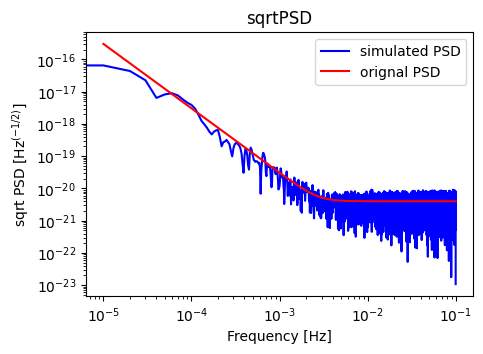

In [29]:
### check the results
df = 1e-5
fmin = 1e-5
fmax = 1e-1
f = np.arange(fmin,fmax,df)
################
# PSD = TQPSD(f)
PSD = LISAPSD(f)
################
fNyq = fmax
TimeSeries = psd2timeseries(PSD, fNyq)[0]
TimeVector = psd2timeseries(PSD, fNyq)[1]

freq, Pxx = signal.periodogram(TimeSeries,2*fNyq, 'flattop', scaling='density')
# freq, Pxx = signal.periodogram(TimeSeries,2*fNyq, 'hanning', scaling='density')
plt.figure(figsize=(5,3.5),dpi=100)
plt.loglog(freq, np.sqrt(Pxx),'b',label='simulated PSD')
plt.loglog(f,np.sqrt(PSD),'r',label='orignal PSD')
plt.title('sqrtPSD')
plt.xlabel('Frequency [Hz]')
plt.ylabel('sqrt PSD [Hz$^{(-1/2)}$]')
plt.legend()

# Pxx, freq = plt.psd(TimeSeries, NFFT=len(f), Fs=2*fNyq)
# freqs, psd = signal.welch(TimeSeries, 2*fNyq, 'flattop', 1024)
# plt.loglog(freqs, np.sqrt(psd),'b')
# plt.loglog(f,np.sqrt(PSD,'r')

In [32]:
fs = (fmax - fmin)/df
print('sampling frequency is: %f Hz' %fs)

sampling frequency is: 9999.000000 Hz


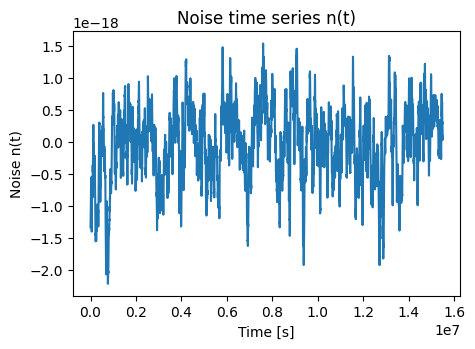

In [14]:
### data used in the real simulation
df = 1/YearInS
fmin = 1e-5
fmax = 6e-4
f = np.arange(fmin,fmax,df)
################
# PSD = TQPSD(f)
PSD = LISAPSD(f)
################
fNyq = fmax
TimeSeries = psd2timeseries(PSD, fNyq)[0]
TimeVector = psd2timeseries(PSD, fNyq)[1]
Noise_t = TimeSeries[1:len(f)]
plt.figure(figsize=(5,3.5),dpi=100)
plt.plot(TimeVector,Noise_t)
plt.title('Noise time series n(t)')
plt.xlabel('Time [s]')
plt.ylabel('Noise n(t)')
plt.show()

# Data model

In [11]:
# Let's choose some values for our injected signal
tc_true     = Tc
phic_true   = Phic
mc_true     = Mc
eta_true    = Eta
dl_true     = DL
thetas_true = ThetaS
phis_true   = PhiS
iota_true   = Iota
psi_true    = Psi

# injected signal parameter
print('tc_true    :', Tc)
print('phic_true  :', Phic)
print('mc_true    :', Mc)
print('eta_true   :', Eta)
print('dl_true    :', DL)
print('thetas_true:', ThetaS)
print('phis_true  :', PhiS)
print('iota_true  :', Iota)
print('psi_true   :', Psi)

tc_true    : 15452640.0
phic_true  : 0.954
mc_true    : 24.28408575389752
eta_true   : 0.08264462809917357
dl_true    : 7.023197515868895e+17
thetas_true: 1.325
phis_true  : 2.04
iota_true  : 1.02
psi_true   : 0.658


Observation time: 0.500000 year
Sampling time interval: 833.333333 second


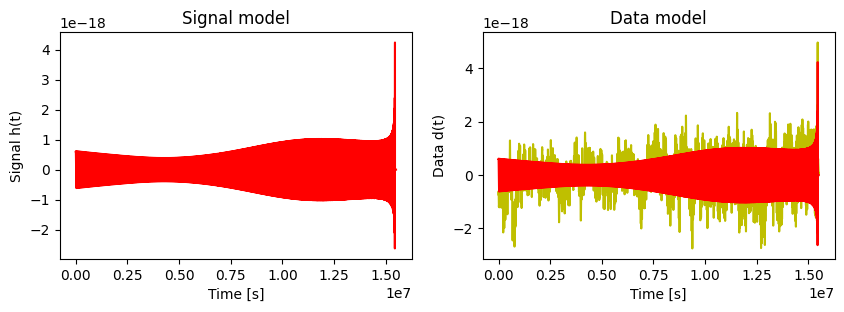

In [19]:
print('Observation time: %f year'%Tobs)
print('Sampling time interval: %f second'%(TimeVector[2]-TimeVector[1]))
h_t = ht_model(TimeVector, tc_true, phic_true, mc_true, eta_true, dl_true, thetas_true, phis_true, iota_true, psi_true)
Data = h_t + Noise_t

plt.figure(figsize=(10,3),dpi=100)
plt.subplot(1,2,1)
plt.plot(TimeVector,h_t, color='r')
plt.title('Signal model')
plt.xlabel('Time [s]')
plt.ylabel('Signal h(t)')
plt.subplot(1,2,2)
plt.plot(TimeVector,Data,color='y')
plt.plot(TimeVector,h_t, color='r')
plt.title('Data model')
plt.xlabel('Time [s]')
plt.ylabel('Data d(t)')
plt.show()

In [14]:
mu = np.mean(Noise_t)
sigma = np.std(Noise_t)
print('mu: ',np.mean(Noise_t))
print('sigma: ',np.std(Noise_t))

mu:  -1.4488653834920476e-20
sigma:  5.673928441939996e-19


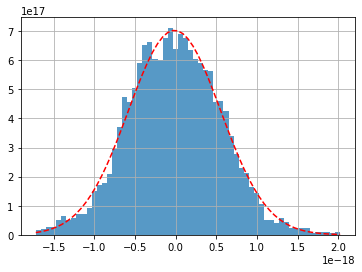

In [15]:
# import seaborn as sns
# sns.distplot(Noise_t,color="g")
from scipy.stats import norm
x = Noise_t
mu =np.mean(x) 
sigma =np.std(x) 
num_bins = 60 
n, bins, patches = plt.hist(x, num_bins,density=1, alpha=0.75) 
y = norm.pdf(bins, mu, sigma)
plt.grid(True)
plt.plot(bins, y, 'r--')

# Bayesian Parameter Estimation

## 使用pymc

In [16]:
# help(pymc.MCMC)

In [17]:
t = TimeVector
y_true = h_t
y_obs = Data

In [18]:
# Helper data to keep track of everything
parameters = ['tc','phic','mc','eta','dl','theta','phi','iota','psi']
## lntc,lnmc,lndl,costheta,cosiota
# bounds = {'tc':(0,Tobs*YearInS), 'phic':(0,2*np.pi), 'mc':(0,10*Mc), 'eta':(0,0.25), 'dl':(0,10*DL), 
#           'theta':(-np.pi/2,np.pi/2), 'phi':(0,2*np.pi), 'iota':(-np.pi/2,np.pi/2), 'psi':(0,np.pi)}

bounds = {'tc':(Tc-Tc*2e-5,Tc+Tc*2e-5), 'phic':(Phic-0.4,Phic+0.4), 'mc':(Mc-Mc*3e-3,Mc+Mc*3e-3), 'eta':(0,0.25), 'dl':(0.8*DL,1.2*DL), 
          'theta':(ThetaS-0.2,ThetaS+0.2), 'phi':(PhiS-0.2,PhiS+0.2), 'iota':(Iota-0.6,Iota+0.6), 'psi':(Psi-0.2,Psi+0.2)}

# bounds = {'tc':(0,10), 'phic':(0,2*np.pi), 'mc':(0,10), 'eta':(0,0.25), 'dl':(0,20), 
#           'theta':(-1,1), 'phi':(0,2*np.pi), 'iota':(-np.pi/2,np.pi/2), 'psi':(0,np.pi)}

# Defining our parameters using pymc.Uniform()
tc = pymc.Uniform('tc', bounds['tc'][0], bounds['tc'][1], \
         value = bounds['tc'][0] + (bounds['tc'][1]-bounds['tc'][0])*np.random.random())

phic = pymc.Uniform('phic', bounds['phic'][0], bounds['phic'][1], \
     value = bounds['phic'][0] + (bounds['phic'][1]-bounds['phic'][0])*np.random.random())

mc = pymc.Uniform('mc', bounds['mc'][0], bounds['mc'][1], \
    value = bounds['mc'][0] + (bounds['mc'][1]-bounds['mc'][0])*np.random.random())

eta = pymc.Uniform('eta', bounds['eta'][0], bounds['eta'][1], \
     value = bounds['eta'][0] + (bounds['eta'][1]-bounds['eta'][0])*np.random.random())

dl = pymc.Uniform('dl', bounds['dl'][0], bounds['dl'][1], \
    value = bounds['dl'][0] +  (bounds['dl'][1]-bounds['dl'][0])*np.random.random())

theta = pymc.Uniform('theta', bounds['theta'][0], bounds['theta'][1], \
     value = bounds['theta'][0] +  (bounds['theta'][1]-bounds['theta'][0])*np.random.random())

phi = pymc.Uniform('phi', bounds['phi'][0], bounds['phi'][1], \
     value = bounds['phi'][0] +  (bounds['phi'][1]-bounds['phi'][0])*np.random.random())

iota = pymc.Uniform('iota', bounds['iota'][0], bounds['iota'][1], \
     value = bounds['iota'][0] +  (bounds['iota'][1]-bounds['iota'][0])*np.random.random())

psi = pymc.Uniform('psi', bounds['psi'][0], bounds['psi'][1], \
     value = bounds['psi'][0] +  (bounds['psi'][1]-bounds['psi'][0])*np.random.random())

In [19]:
@pymc.deterministic
def y_model(t=t, tc=tc, phic=phic, mc=mc, eta=eta, dl=dl, theta=theta, phi=phi, iota=iota, psi=psi):
    return ht_model(t, tc, phic, mc, eta, dl, theta, phi, iota, psi)

# @pymc.deterministic
# def y_model(t=t, tc=tc, phic=phic, mc=mc, eta=eta, dl=dl, theta=theta, phi=phi):
#     return ht_model(t, tc, phic, mc, eta, dl, theta, phi, Iota, Psi)

# @pymc.deterministic
# def y_model(t=t, tc=tc, phic=phic, mc=mc, eta=eta, dl=dl, theta=theta, phi=phi):
#     return ht_model(t, 10**tc, phic, 10**mc, eta, 10**dl, acos(theta), phi, Iota, Psi)

In [20]:
y = pymc.Normal('y', mu=y_model, tau=sigma**-2, observed=True, value=y_obs)
M = pymc.MCMC([y, tc, phic, mc, eta, dl, theta, phi, iota, psi, y_model])
# M = pymc.MCMC([y, tc, phic, mc, eta, dl, theta, phi, y_model])
# M.sample(iter=2e5, burn=1e4, thin=1)
M.sample(iter=1e5)

 [-----------------100%-----------------] 100001 of 100000 complete in 4573.6 sec

Plotting iota
Plotting phic
Plotting theta
Plotting tc
Plotting psi
Plotting dl
Plotting mc
Plotting eta
Plotting phi


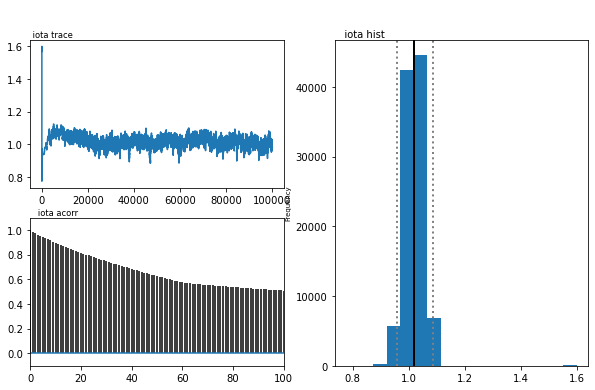

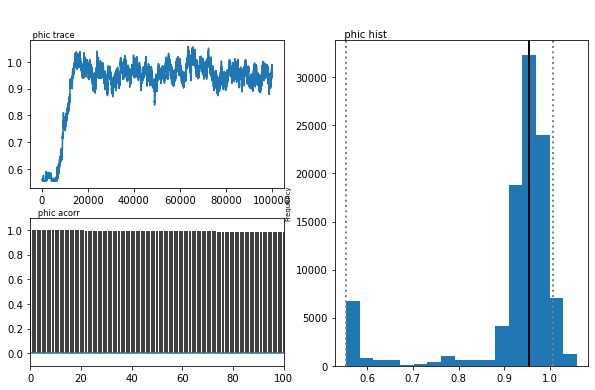

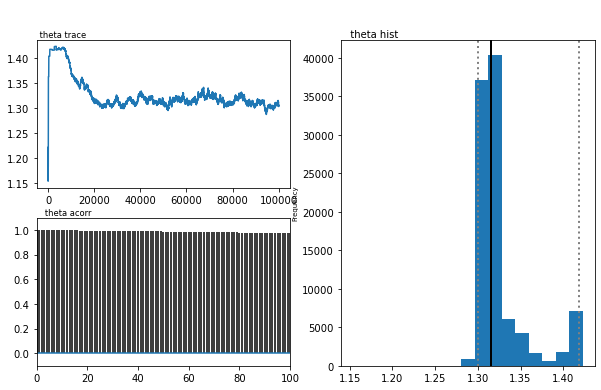

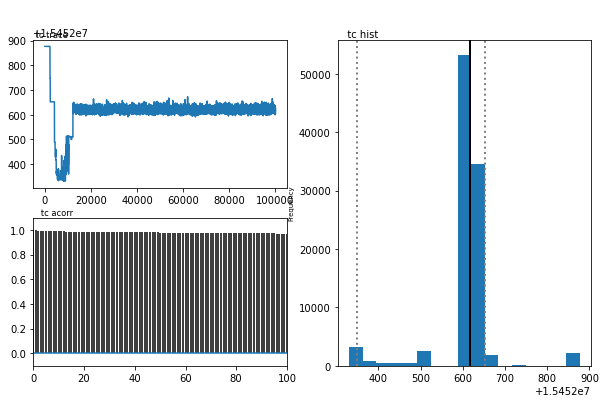

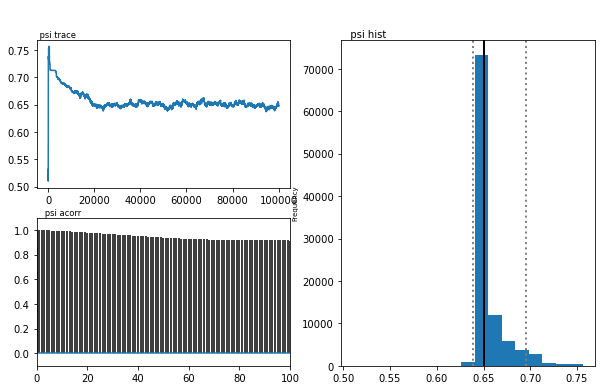

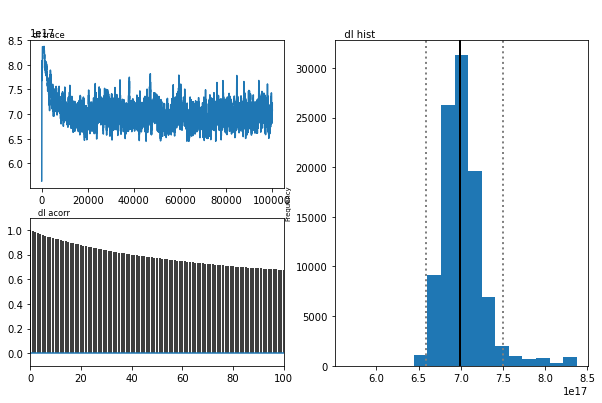

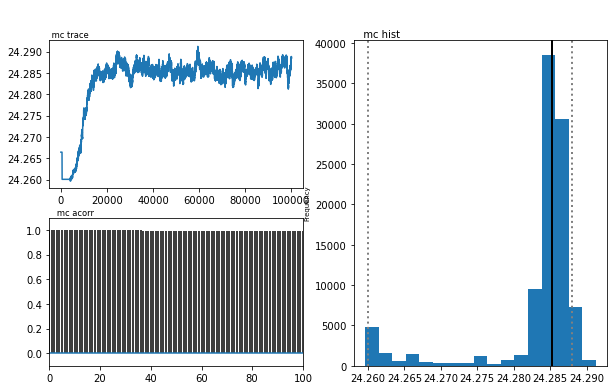

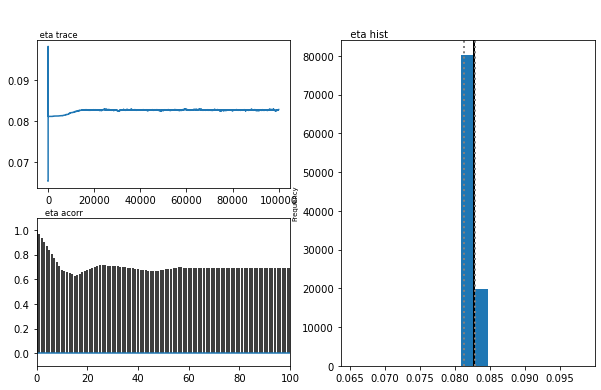

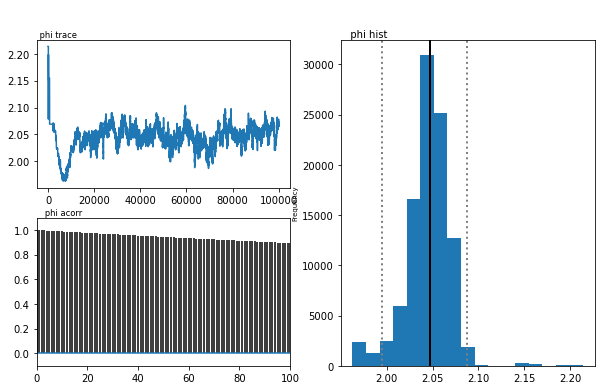

In [21]:
pymc.Matplot.plot(M)

In [22]:
# Convert the results of our MCMC sampling
def mcmc_dataframe(M, skip_vars):
    names = []
    data = []
    for var in M.variables:
        try:
            name = var.trace.name
            if name not in skip_vars:
                names.append(var.trace.name)
                data.append(var.trace.gettrace().tolist())
        except AttributeError:
            pass
    df = pd.DataFrame(data).T
    df.columns = names
    return df

# Save as csv
mcmc_dataframe(M, ['y_model']).to_csv('Bayes_PE.csv')

In [23]:
# Load up the samples. Using pregenerated; change
# the filename if you want to load your own.
samples = pd.read_csv('Bayes_PE.csv')

In [24]:
var_order = ['tc','phic','mc','eta','dl','theta','phi','iota','psi']
# var_order = ['tc','phic','mc','eta','dl','theta','phi']
for i in range(len(var_order)):
    print(var_order[i],':',samples[var_order[i]].median())

tc : 15452617.66262525
phic : 0.9537784952847416
mc : 24.28523210939427
eta : 0.08269750986868411
dl : 6.994433952311974e+17
theta : 1.3149390165522985
phi : 2.047443158479849
iota : 1.0192818302544158
psi : 0.6507745433094779


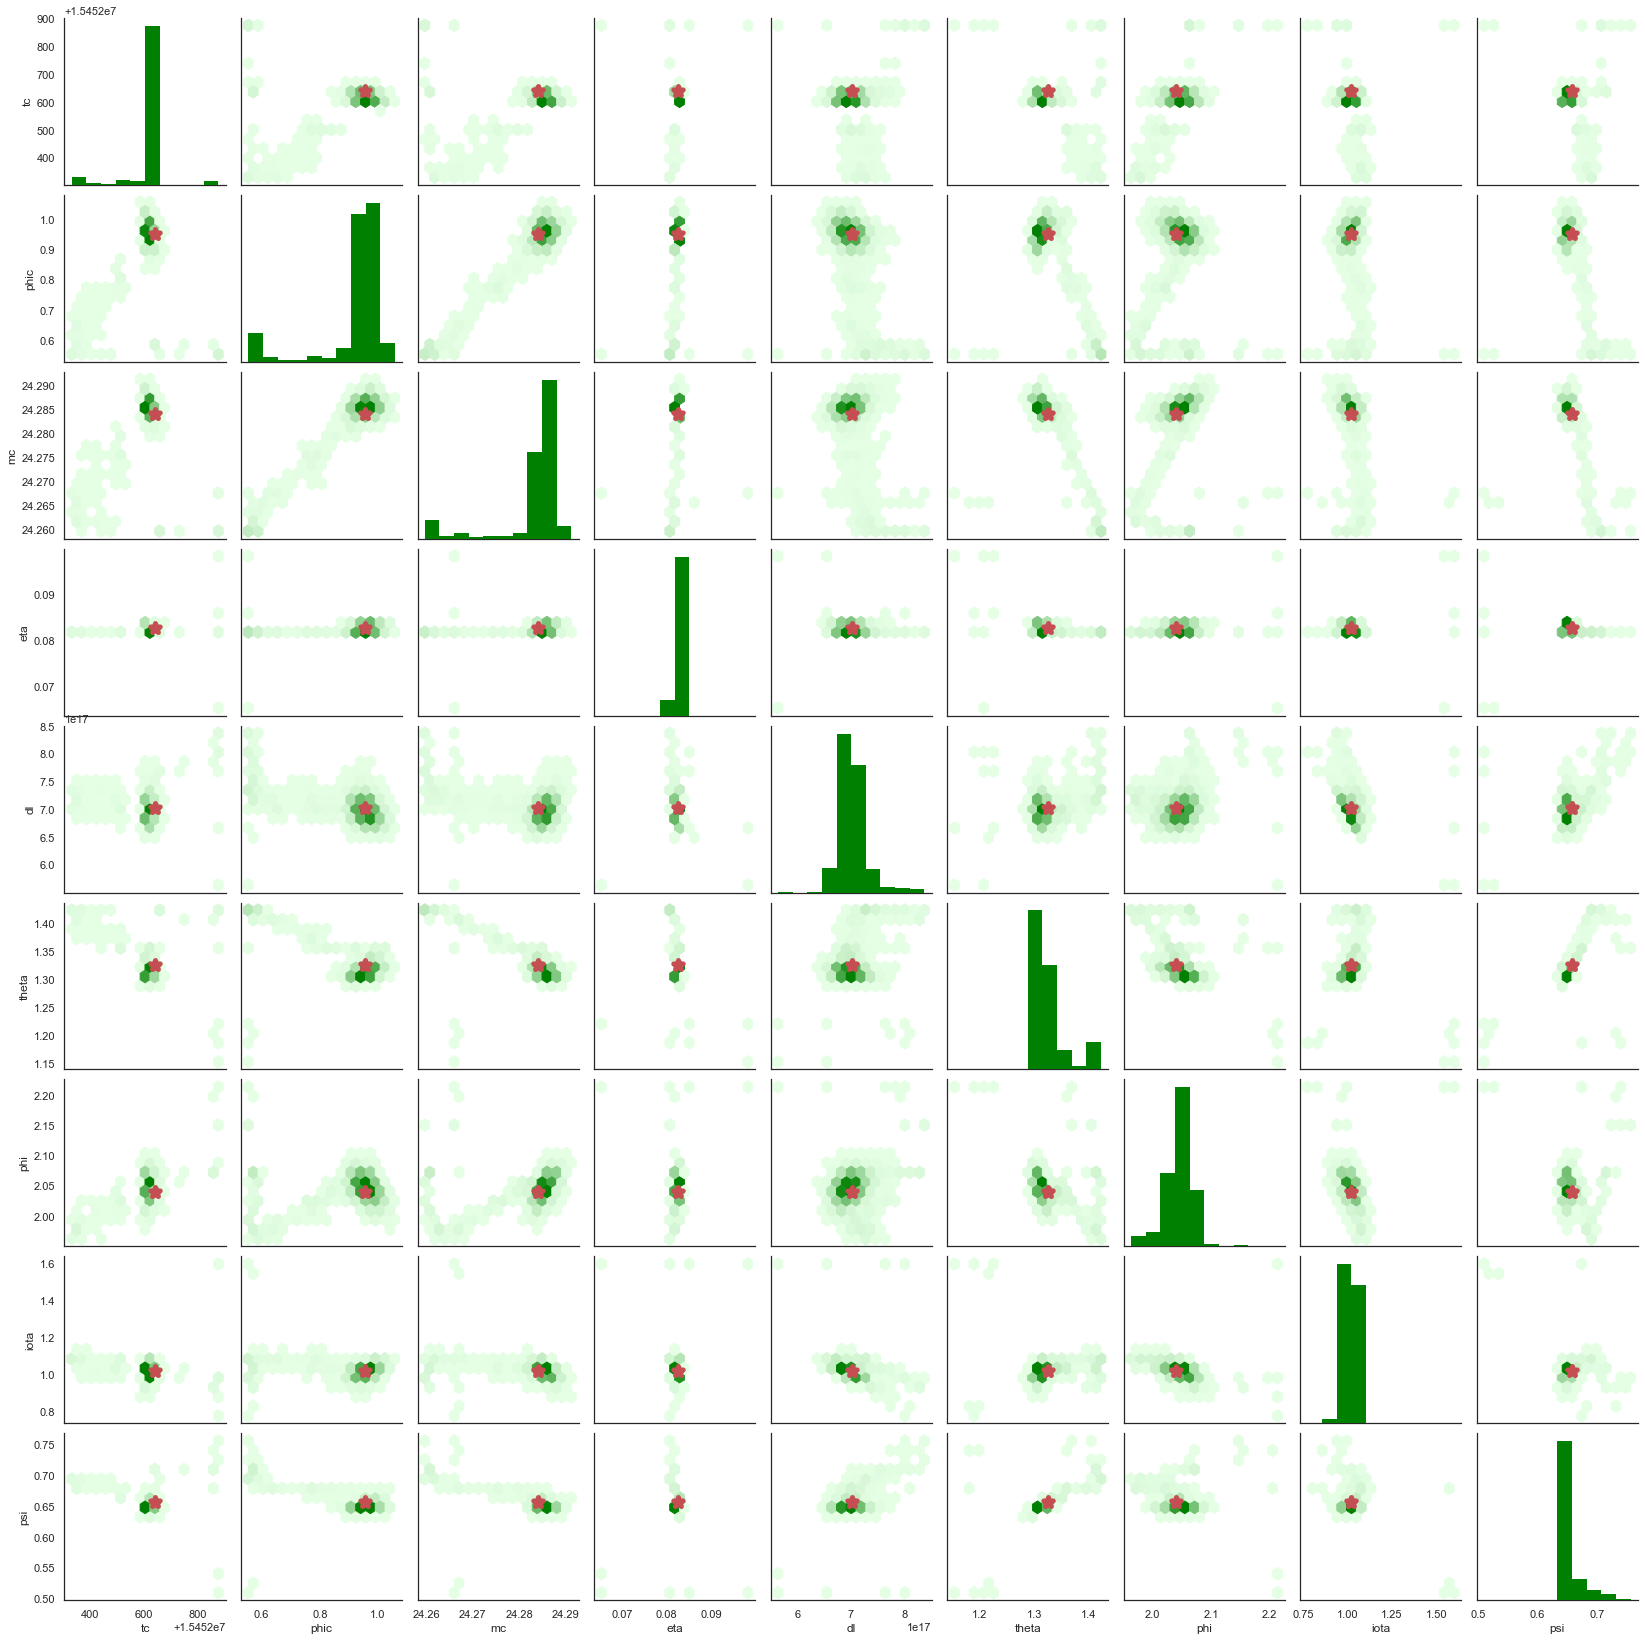

In [25]:
# Some settings for Seaborn
sns.set(context='notebook', style="ticks", color_codes=True)

# Wrapper function for the hexbin plotting style
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=15, cmap = cmap, mincnt = 1)
    return

# Helper arrays
truth = [tc_true, phic_true, mc_true, eta_true, dl_true, thetas_true, phis_true, iota_true, psi_true]
est = samples[var_order].max().values

# Plot a pairwise grid of scatter plots and histograms
with sns.axes_style("white"):
    g = sns.pairplot(
        samples[var_order],
        # We don't actually want the scatter plots, so we set the marker size to 0
        plot_kws={"s": 0}, 
        diag_kws={'color': 'green', 'lw': 0})
    
    # Replace the scatter plots with hexbin plots
    g.map_offdiag(hexbin, color='green');

# Plot the injected values in the histograms
for i in range(len(var_order)):
    for j in range(len(var_order)):
        if i != j:
            ax = g.axes[i,j]
            ax.scatter([truth[j]], [truth[i]], color = "r", marker = '*', s=100, linewidths=5)
# plt.savefig('paras.png', dpi=400, bbox_inches='tight')

## pymc3-test

In [26]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# import matplotlib as mpl
# import pymc3 as pm
# from pymc3 import Model, Normal, Slice
# from pymc3 import sample
# from pymc3 import traceplot
# from pymc3.distributions import Interpolated
# from theano import as_op
# import theano.tensor as tt
# import numpy as np
# from scipy import stats

# plt.style.use('seaborn-darkgrid')
# print('Running on PyMC3 v{}'.format(pm.__version__))

In [27]:
# import pymc3 as pm

# t = np.arange(-Tobs,-1000,3000)

# # Noise strength
# sigma = 10**(-18)

# # Injecting our signal into the noise
# h_ture = ht_respon_TQ(t, Tc, Phic, Mc, Eta, DL, ThetaS, PhiS, Iota, Psi)
# D_obs = np.random.normal(h_ture, sigma)

# basic_model = pm.Model()
# with basic_model:
#     tc    = pm.Uniform('tc',-1e8,0)
#     phic  = pm.Uniform('phic',0,2*np.pi)
#     mc    = pm.Uniform('mc',0,1e2)
#     eta   = pm.Uniform('eta',0,0.25)
#     dL    = pm.Uniform('dL',0,1e20)
# #     theta = acos(pm.Uniform('theta',-1,1)) 
#     theta = pm.Uniform('theta',-np.pi,np.pi)
#     phi   = pm.Uniform('phi',0,2*np.pi) 
# #     iota  = acos(pm.Uniform('iota',-1,1)) 
#     iota  = pm.Uniform('iota',-np.pi,np.pi)
#     psi   = pm.Uniform('psi',0,2*np.pi) 
    
#     mu = ht_respon_TQ(t, tc, phic, mc, eta, dL, theta, phi, iota, psi)
    
#     D = pm.Normal('D',mu=mu,sd=sigma,observed=D_obs)

#     trace = pm.sample(5000)
#     pm.traceplot(trace);

# pm.summary(trace)

# # map_estimate = pm.find_MAP(model=basic_model)
# # from scipy import optimize
# # map_estimate2 = pm.find_MAP(model=basic_model,fmin=optimize.fmin_powell)
# # print(map_estimate)
# # print(map_estimate2)

In [28]:
# Frequency-domain waveform

# def hf_respon_amp_LISA(f, tc, phic, mc, eta, dl, thetaS, phiS, iota, psi):
#     """the frequency-domain amplitude: 1st 60 degree MI with antenna response (contain plus and cross mode) for LISA"""

#     v = (np.pi*mc*f)**(2./3)*eta**(-2./5)
    
#     #"""function t(f) for non-spinning 3PN correction"""  
#     SO, SS = 0, 0 
#     rE = 0.577216
#     t = tc-5./256*(mc)**(-5./3)*(np.pi*f)**(-8./3)*(1                    
#              + 4./3*(743./336 + 11*eta/4.)*v                 
#              - 8./5*(4*np.pi - SO)*v**(3./2)                  
#              + (3058673./508032 + 5429./504*eta + 617./72*eta**2 - 2*SS)*v**2 )                  

#     #"""For LISA (one Michelson interferometer): (thetaS,phiS) is location of source"""
#     alpha = 2*np.pi/YearInS* t-np.pi/9 # trailing 20°behind the Earth (-np.pi/9)
#     lam = 3*np.pi/4-np.pi/9
#     Dplus_LISA = np.sqrt(3.)/64*(-36*(np.sin(thetaS))**2 *np.sin(2*alpha-2*lam) +(3+np.cos(2*thetaS))*(np.cos(2*phiS)*(9*np.sin(2*lam)-np.sin(4*alpha-2*lam)) \
#             + np.sin(2*phiS)*(np.cos(4*alpha-2*lam)-9*np.cos(2*lam)))-4*np.sqrt(3.)*np.sin(2*thetaS)*(np.sin(3*alpha-2*lam-phiS)-3*np.sin(alpha-2*lam+phiS)))

#     Dcros_LISA = 1/16*(np.sqrt(3.)*np.cos(thetaS)*(9*np.cos(2*lam-2*phiS)-np.cos(4*alpha-2*lam-2*phiS))-6*np.sin(thetaS)*(np.cos(3*alpha-2*lam-phiS)+3*np.cos(alpha-2*lam+phiS)))

#     #"""antenna pattern function for '+' mode"""
#     Fplus_LISA = (np.cos(2*psi)*Dplus_LISA-np.sin(2*psi)*Dcros_LISA)/2.

#     #"""antenna pattern function for '×' mode"""
#     Fcros_LISA = (np.sin(2*psi)*Dplus_LISA+np.cos(2*psi)*Dcros_LISA)/2.

#     #"""1st MI angular response function for LISA"""
#     Q_LISA = np.sqrt((1+(np.cos(iota))**2)**2*(Fplus_LISA)**2 
#              +(2*np.cos(iota))**2*(Fcros_LISA)**2)

#     #"""inspiral amplitude including mass and distance terms"""
#     A = -np.sqrt(5./96)*(mc)**(5./6)/np.pi**(2./3)/(dl)

#     #"""1st MI polarization phase for LISA"""
#     phip_LISA = np.arctan(2*np.cos(iota)*Fcros_LISA/((1+(np.cos(iota))**2)*Fplus_LISA))  

#     #"""Doppler phase for LISA"""
#     phi0 = -np.pi/9 # trailing 20°behind the Earth
#     phiD_LISA = 2*np.pi*f*AUInS*np.sin(thetaS)*np.cos(2*np.pi*t/YearInS+phi0-phiS)

#     #"""non-precesnp.sing spinning PN correction to the GW phase"""
#     beta  = 0.0
#     sigma = 0.0
# #         chi   = chi1
# #         beta  = 113./12*chi-19./6*eta*(chi1+chi1)
# #         sigma = 81./16*chi**2-1./4*eta*chi1*chi1
# #         gamma = (732985./2268+140./9*eta)*chi-(12760./81*eta+170./9*eta**2)*(chi1+chi1)
# #         xi    = 75./2*np.pi*chi-37./3*np.pi*eta*(chi1+chi1)
#     PSI_PN = 2*np.pi*f*tc-phic-np.pi/4 +3./128*(mc*np.pi*f)**(-5./3)* (1    \
#            + (3715./756 + 55./9*eta)*v \
#            + (4*beta-16*np.pi)*v**(3./2)  \
#            + (15293365./508032+27145./504*eta+3085./72*eta**2-10*sigma)*v**2  ) 

#     #"""1st MI total GW phase for LISA"""
#     PSI_LISA = PSI_PN + phip_LISA - phiD_LISA

#     return Q_LISA*A*f**(-7./6)*np.exp(1j*PSI_LISA)

In [29]:
## FIM_RMS

In [30]:
# FIMparams = ['tc','phic','mc','eta','dL','thetaS','phiS','chi1'] # Input parameter space 
# form_rms = "[{:.3f}, {:.3f}, {:.3e}, {:.3e}, {:.3e}, {:.4f}, {:.4f}, {:.3e}]"
# # FIMparams = ['tc','phic','mc','eta','dL','thetaS','phiS'] # Input parameter space 
# # form_rms = "[{:.3f}, {:.3f}, {:.3e}, {:.3e}, {:.3e}, {:.4f}, {:.4f}]"

# ## FIM
# GammaTQ = Gamma_TQ(FIMparams,THETA,Q_TQ,TQfreq_int,TQsqrtPSD_int,HfResponAmp_TQ)
# Gamma2TQ = Gamma2_TQ(FIMparams,THETA,Q2_TQ,TQfreq_int,TQsqrtPSD_int,HfResponAmp2_TQ)
# GammaLISA = Gamma_LISA(FIMparams,THETA,Q_LISA,LISAfreq_int,LISAsqrtPSD_int,HfResponAmp_LISA)
# Gamma2LISA = Gamma2_LISA(FIMparams,THETA,Q2_LISA,LISAfreq_int,LISAsqrtPSD_int,HfResponAmp2_LISA)

# ## using linalg.inv to invert FIM
# ## 测试显示改方法比SVD计算偏差更小！
# GammaT = GammaTQ + Gamma2TQ
# GammaL = GammaLISA + Gamma2LISA
# GammaTL = GammaT + GammaL
# Sigma_TQ = np.linalg.inv(GammaT)
# Sigma_LISA = np.linalg.inv(GammaL)
# Sigma_TQLISA = np.linalg.inv(GammaTL)

# ## RMS errors
# RMS_TQ = np.sqrt(np.diag(Sigma_TQ))
# RMS_LISA = np.sqrt(np.diag(Sigma_LISA))
# RMS_TQLISA = np.sqrt(np.diag(Sigma_TQLISA))

# ## sky localization
# D_Omega_TQ = 2.*np.pi*abs(sin(ThetaS))*np.sqrt(Sigma_TQ[5,5]*Sigma_TQ[6,6]-Sigma_TQ[5,6]*Sigma_TQ[6,5])
# D_Omega_LISA = 2.*np.pi*abs(sin(ThetaS))*np.sqrt(Sigma_LISA[5,5]*Sigma_LISA[6,6]-Sigma_LISA[5,6]*Sigma_LISA[6,5])
# D_Omega_TQLISA = 2.*np.pi*abs(sin(ThetaS))*np.sqrt(Sigma_TQLISA[5,5]*Sigma_TQLISA[6,6]-Sigma_TQLISA[5,6]*Sigma_TQLISA[6,5])

In [31]:
## SNR

In [32]:
# form_f = "[{:.3e}, {:.3e}]"
# print("frequency band:", form_f.format(*FreqLowHigh(THETA)))
# TQ_SNR = np.sqrt(GammaT[4,4])
# print("SNR for TianQin with antenna function: %.1f" % TQ_SNR)
# LISA_SNR = np.sqrt(GammaL[4,4])
# print("SNR for LISA with antenna function: %.1f" % LISA_SNR)
# TQLISA_SNR = np.sqrt(GammaTL[4,4])
# print("SNR for TQ+LISA with antenna function: %.1f" % TQLISA_SNR)  

In [33]:
## RMS

In [34]:
# ### 求导表达式去掉ATomc, QTomc, QToeta
# print(FIMparams)
# print("RMS_TQ:", form_rms.format(*RMS_TQ))
# print("D_Omega_TQ: %.3e" % D_Omega_TQ)
# print("RMS_LISA:", form_rms.format(*RMS_LISA)) 
# print("D_Omega_LISA: %.3e" % D_Omega_LISA)
# print("RMS_TQLISA:", form_rms.format(*RMS_TQLISA))
# print("D_Omega_TQLISA: %.3e" % D_Omega_TQLISA)

In [35]:
## Condition number & Max Difference

In [36]:
# ### condition number
# print("condition number for TQ: %.3e" % np.linalg.cond(GammaT))
# print("condition number for LISA: %.3e" % np.linalg.cond(GammaL))
# print("condition number for TQ&LISA: %.3e" % np.linalg.cond(GammaTL))
# ### Absolute Difference from the Identity Matrix
# AbsDiff_TQ = (np.dot(GammaT, Sigma_TQ)-np.eye(len(FIMparams))).max()
# AbsDiff_LISA = (np.dot(GammaL, Sigma_LISA)-np.eye(len(FIMparams))).max()
# AbsDiff_TQLISA = (np.dot(GammaTL, Sigma_TQLISA)-np.eye(len(FIMparams))).max()
# form = "[{:.3e}, {:.3e}, {:.3e}]"
# print("maximum absolute difference from the identity matrix:", form.format(AbsDiff_TQ, AbsDiff_LISA, AbsDiff_TQLISA))